In [1]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

pd.options.mode.chained_assignment = None  # silence pandas copy warning

FILEPATH_DATA = "data//quantified_self_data_full.csv"

df = pd.read_csv(FILEPATH_DATA)

## Data Preparation

Here's a legend of the different data values in the csv files:
- Exercise: Number of minutes exercised on that day
- Climbing: Climbed on that day (0 = no, 1, = yes)
- Sweets: Number of sweets/desserts eaten that day
- EatingOut: Number of meals eaten out that day
- Coffee: Number of coffees drunk that day
- Tea: Number of cups of tea drunk that day
- Water: Liters of water drunk that day
- DayRating: Subjective rating of how good the day was (-1 = bad, 0 = normal, 1 = good)
- HoursSleep: Hours of sleep the previous night
- Sunny: How sunny the day was (-1 = cloudy, 0 = mixed sun & clouds, 1 = sunny)
- Rain: Did it rain that day (0 = no, 1 = yes)
- Temperature: temperature high that day
- Weight: weight in kilograms on that day (measured in the morning, right after waking up)

Below I prepare the data to be fed into several machine learning models which attempt to predict my weight on the next day, given the data from the current day and possibly also preceding days.

### Data Exploration

As a first step, let's look at a summary of the data

In [2]:
df.describe()

,Exercise,Climbing,Sweets,EatingOut,Coffee,Tea,Water,DayRating,HoursSleep,Sunny,Rain,Temperature,Weight
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,629.000000
mean,15.186301,0.093151,0.498630,0.604110,3.694521,1.254795,1.531644,0.016438,7.296239,0.030137,0.263014,15.730137,74.903657
std,22.827097,0.290843,0.710975,0.709129,0.979122,1.016063,0.500314,0.479773,1.082343,0.889920,0.440572,9.279078,1.618072
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,-1.000000,4.000000,-1.000000,0.000000,-8.000000,70.500000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.200000,0.000000,6.500000,-1.000000,0.000000,8.000000,74.200000
50%,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.400000,0.000000,7.000000,0.000000,0.000000,16.000000,75.200000
75%,40.000000,0.000000,1.000000,1.000000,4.000000,2.000000,1.800000,0.000000,8.000000,1.000000,1.000000,23.000000,76.100000
max,120.000000,1.000000,4.000000,3.000000,7.000000,7.000000,5.000000,1.000000,11.500000,1.000000,1.000000,37.000000,78.400000


The features in the data range across a couple different types (continuous, binary, factors) and ranges, so we will need to normalize them for the neural network. The weight feature, which is also the target we're trying to predict, is missing some values, as we can see from the count row. If we look at the percent of NaNs in each column we see that unfortunately roughly 14% of the data is missing.

In [3]:
# Fraction of NaNs in each column
df.isna().sum() / len(df)

Date           0.000000
Exercise       0.000000
Climbing       0.000000
Sweets         0.000000
EatingOut      0.000000
Coffee         0.000000
Tea            0.000000
Water          0.000000
DayRating      0.000000
HoursSleep     0.000000
Sunny          0.000000
Rain           0.000000
Temperature    0.000000
Weight         0.138356
dtype: float64

There are various interpolation schemes that one could use to try fill in the missing values, but for the purposes of modeling I'll simply not use values with no recorded weight, to avoid changing/biasing the underlying distribution. This has the drawback of reducing an even small dataset further, but that's how the proverbial cookie crumbles.

### Feature Engineering

Since the data makes up a multivariate time series, it makes since to see if there are any cyclical dependencies in the data. To that end, I take the Fourier transform of the weight column. Since the Fourier transform won't take NaN values, I impute these using linear interpolation, but do not use these imputed values when building my models.

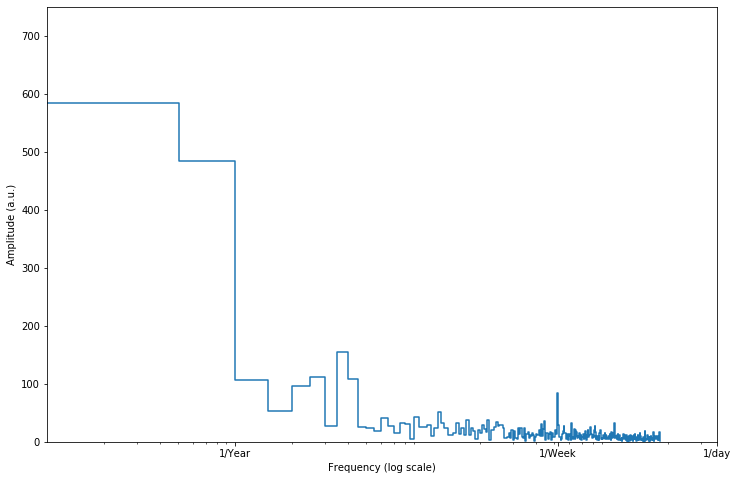

In [4]:
weights_for_fft = df.Weight.copy()

# Get locations of NaNs. 0 idx is NaN because of diff operation, skip it
nan_start_idxs = np.asarray(weights_for_fft.isna().diff()).nonzero()[0][1::2]
nan_end_idxs = np.asarray(weights_for_fft.isna().diff()).nonzero()[0][2::2]

# Impute weights
for start_idx, end_idx in zip(nan_start_idxs, nan_end_idxs):
    interval_length = end_idx - start_idx
    imputed_weights = np.linspace(weights_for_fft[start_idx - 1], weights_for_fft[end_idx], interval_length + 2)[1:-1]
    weights_for_fft[start_idx:end_idx] = imputed_weights

# Get fft
fft = tf.signal.rfft(weights_for_fft)
f_per_dataset = np.arange(0, len(fft))

n_samples_day = len(weights_for_fft)
days_per_year = 365.25
years_per_dataset = n_samples_day/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 750)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 52, 365.25], labels=['1/Year', '1/Week', '1/day'])
plt.xlabel('Frequency (log scale)')
plt.ylabel('Amplitude (a.u.)')
plt.show()

There seems to be a clear peak on the time scale of a week, so let's add a sine and cosine feature to our dataset with a period of a week. Also I'll drop the Date column and add a Label column, which is the Weight variable offset by one day.

In [5]:
# Add week cosine/sine features
df['WeekSin'] = np.sin(df.index * (2 * np.pi / 7))
df['WeekCos'] = np.cos(df.index * (2 * np.pi / 7))

# Drop Date field since classifer can't use it and it's not a useful feature.
df = df.drop('Date', 1)

# Add label column
df["Label"] = df.Weight.copy()
df.Label[:-1] = df.Weight[1:]
df.drop(df.tail(1).index,inplace=True) # drop last row as we don't have a Label value for it

We now have 15 features and 629 non-NaN data points, which is not a ton of data, so it would be nice to reduce the number of features in our dataset. Though there are various ways to try to do this, I'll go for a simple strategy where I only keep variables which I expect *a priori* to influence weight, then I'll test that along with the original dataset to see which one performs best. 

In [6]:
df_reduced = df.copy()
features_to_drop = ["DayRating", "HoursSleep", "Sunny", "Rain", "Temperature", ]

# Only keep expected features
for feature in features_to_drop:
    df_reduced = df_reduced.drop(feature, 1)

Finally I save the finished data frames.

In [7]:
df.to_csv("data\dataset_full.csv", index=False)
df_reduced.to_csv("data\dataset_reduced.csv", index=False)